<div align="center">

## **ACM40960 — Project in Mathematical Modelling**  
## *Fantasy Football*
### Shyam Pratap Singh Rathore(24222167) & Charvie Kukreja(24202861)
</div>


### Introduction

The aim of this project is to design a robust machine learning pipeline that predicts player impact in football matches, with direct applications to **Fantasy Football**.  
By leveraging a hybrid of **tree-based model (XGBoost)** and **neural networks (MLP)**, we combine the interpretability of structured models with the flexibility of deep learning. The result is a powerful ensemble that can detect both obvious and subtle performance signals.  

While our demonstration uses **English Premier League 2022/23** data, the framework is fully adaptable - meaning any structured dataset of player statistics can be plugged in to uncover the latest performance patterns. This flexibility makes the approach scalable from course-level projects to **PhD-level research applications** in sports analytics.  

In addition to raw performance metrics (minutes, goals, assists), we engineer **per-90 features, rolling averages, and opponent-strength context** to capture the reality of football dynamics. We then evaluate models using rigorous metrics (ROC-AUC, PR-AUC, F1, confusion matrices), ensuring the predictions are not only accurate but also reliable across thresholds.  

Ultimately, this project doesn’t just aim to “predict scores” — it builds a **generalizable decision-making tool** for team selection, tactical analysis, and fantasy football optimisation.  


## 1. Setup & Imports
We begin by initialising the project environment.
We load essential libraries for data handling (numpy, pandas), visualization (matplotlib), and machine learning (scikit-learn, XGBoost).
We also configure reproducibility with a fixed random seed and set the dataset path.

In [28]:
# =========================================================
# SETUP & IMPORTS
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, classification_report, confusion_matrix, f1_score
)
from sklearn.inspection import permutation_importance

# Applying XGBoost
XGB_AVAILABLE = False
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Local config
DATA_PATH = "/Users/shyam/Desktop/Final Project/epl2022_player_stats.csv"  # <-- change as per your directory


## 2. Data Load & Audit

Here we load the raw player statistics dataset (epl2022_player_stats.csv) into a DataFrame.
We then perform a quick audit to inspect data types, missing values, and unique counts for each column, ensuring the dataset is ready for cleaning.

In [23]:
# =========================================================
# LOAD & AUDIT
# =========================================================
df = pd.read_csv(DATA_PATH)

audit = pd.DataFrame({
    "column": df.columns,
    "dtype": [str(df[c].dtype) for c in df.columns],
    "non_null": df.notnull().sum().values,
    "n_unique": [df[c].nunique() for c in df.columns]
})
display(audit.head(30))
display(df.head(8))


,column,dtype,non_null,n_unique
0,match_id,int64,3555,89
1,team,object,3555,20
2,player,object,3555,626
3,position,object,3555,4
4,minutes,float64,2663,87
5,rating,float64,2586,36
6,goals,float64,223,3
7,assists,float64,163,3
8,shots,float64,1034,9
9,xG,float64,0,0


,match_id,team,player,position,minutes,rating,goals,assists,shots,xG,passes,key_passes,yellow_cards,red_cards
0,867946,Crystal Palace,Vicente Guaita,G,90.0,6.2,NaN,NaN,NaN,NaN,37.0,NaN,0,0
1,867946,Crystal Palace,Nathaniel Clyne,D,90.0,6.3,NaN,NaN,NaN,NaN,56.0,1.0,1,0
2,867946,Crystal Palace,Joachim Andersen,D,90.0,7.9,NaN,NaN,NaN,NaN,104.0,1.0,0,0
3,867946,Crystal Palace,Marc Guéhi,D,90.0,6.3,NaN,NaN,NaN,NaN,105.0,NaN,0,0
4,867946,Crystal Palace,Tyrick Mitchell,D,90.0,6.3,NaN,NaN,NaN,NaN,52.0,NaN,0,0
5,867946,Crystal Palace,Cheick Doucouré,M,75.0,6.7,NaN,NaN,NaN,NaN,34.0,NaN,0,0
6,867946,Crystal Palace,Jeffrey Schlupp,M,86.0,6.9,NaN,NaN,1.0,NaN,35.0,NaN,0,0
7,867946,Crystal Palace,Jordan Ayew,M,90.0,6.2,NaN,NaN,NaN,NaN,30.0,3.0,0,0


## 3. Data Cleaning & Target Definition

This block cleans and preprocesses the dataset:

-> Converts key columns to numeric.

-> Removes rows where players didn’t play (minutes > 0).

-> Replaces missing numeric stats (goals, assists, etc.) with zeros.

-> Creates a binary target variable (impact) to label impactful players (rating ≥ 7 or contributed goals/assists).

This sets the foundation for a classification problem.

In [4]:
# =========================================================
# - Coerce numerics
# - Minutes > 0
# - Fill counting stats NaNs with 0
# - Target y = 1 if rating >= 7 OR (goals + assists) > 0
# - If xG missing, create it as zeros (warn)
# =========================================================
numeric_cols = ["minutes","rating","goals","assists","shots","passes","key_passes","yellow_cards","red_cards"]
if "xG" not in df.columns:
    print("WARNING: 'xG' column not found. Creating xG=0.0 (note data limitation).")
    df["xG"] = 0.0
numeric_cols.append("xG")

for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[df["minutes"].fillna(0) > 0].copy()

for c in ["goals","assists","shots","xG","passes","key_passes","yellow_cards","red_cards"]:
    if c in df.columns:
        df[c] = df[c].fillna(0.0)

df["impact"] = ((df["rating"] >= 7.0) | ((df["goals"] + df["assists"]) > 0)).astype(int)
print("Class balance:", df["impact"].value_counts(normalize=True).round(3).to_dict())


Class balance: {0: 0.63, 1: 0.37}


## 4. Feature Engineering (Per-90 Metrics & Pruning)

We create per-90 features (e.g., shots90, passes90, xG90) to standardize player performance independent of minutes played.
Next, we prune features with low variance or excessive zeros, ensuring only informative variables are retained.
The resulting feature set becomes the input X, while impact is the label y.

In [8]:
# =========================================================
# Rules:
#   - drop zero-variance features
#   - drop "nearly all zeros" features (zero rate > ZERO_RATE_MAX)
#   - everything else stays
# =========================================================
ZERO_RATE_MAX = 0.995  # tweak if you want to be stricter/looser

def per90(series, minutes):
    m = minutes.values
    v = series.values
    return np.where(m > 0, v * 90.0 / m, 0.0)

# creating per-90s if inputs present
if {"shots","minutes"}.issubset(df.columns):   df["shots90"]  = per90(df["shots"], df["minutes"])
if {"passes","minutes"}.issubset(df.columns):  df["passes90"] = per90(df["passes"], df["minutes"])
if {"key_passes","minutes"}.issubset(df.columns): df["kp90"]  = per90(df["key_passes"], df["minutes"])
if {"yellow_cards","minutes"}.issubset(df.columns): df["yc90"]= per90(df["yellow_cards"], df["minutes"])
if {"red_cards","minutes"}.issubset(df.columns):    df["rc90"]= per90(df["red_cards"], df["minutes"])
if {"xG","minutes"}.issubset(df.columns):           df["xG90"]= per90(df["xG"], df["minutes"])

candidate_features = [
    c for c in [
        "minutes","shots","xG","passes","key_passes","yellow_cards","red_cards",
        "shots90","passes90","kp90","yc90","rc90","xG90"
    ] if c in df.columns
]

# computing stats to prune
stats = []
for c in candidate_features:
    s = df[c]
    zero_rate = float((s == 0).mean())
    var = float(s.var())
    keep = (var > 0) and (zero_rate <= ZERO_RATE_MAX)
    stats.append({"feature": c, "variance": var, "zero_rate": zero_rate, "keep": keep})
prune_df = pd.DataFrame(stats).sort_values("keep", ascending=True)
display(prune_df)

feature_cols = [r["feature"] for r in stats if r["keep"]]
print("Kept features:", feature_cols)

X = df[feature_cols].fillna(0.0).values
y = df["impact"].values


,feature,variance,zero_rate,keep
2,xG,0.000000,1.000000,False
6,red_cards,0.003742,0.996245,False
11,rc90,0.019223,0.996245,False
12,xG90,0.000000,1.000000,False
0,minutes,970.322899,0.000000,True
1,shots,1.043786,0.611716,True
3,passes,524.219783,0.020653,True
4,key_passes,1.047971,0.607585,True
5,yellow_cards,0.115173,0.874202,True
7,shots90,5.748071,0.611716,True


Kept features: ['minutes', 'shots', 'passes', 'key_passes', 'yellow_cards', 'shots90', 'passes90', 'kp90', 'yc90']


## 5. Train-Test Split & Scaling

Here we split the dataset into training and testing sets (75/25) with stratification to preserve class balance.
We then standardize the features using StandardScaler, ensuring that all input variables contribute equally to model training.

In [9]:
idx_all = np.arange(len(df))
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, idx_all, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


## 6. Model Training (XGBoost / GradientBoost + Neural Network)

We train two complementary models:

XGBoost (or GradientBoost as fallback): A tree-based ensemble method great at handling structured data.

Neural Network (MLP): A multi-layer perceptron with early stopping to capture non-linear relationships.
Both models are trained on the processed features to predict impactful players.

In [10]:
# =========================================================
# MODELS (XGB/GradBoost + MLP with early stopping)
# =========================================================
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.08,
        subsample=0.9, colsample_bytree=0.9,
        objective="binary:logistic", eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=2
    )
else:
    from sklearn.ensemble import GradientBoostingClassifier
    xgb = GradientBoostingClassifier(random_state=RANDOM_STATE)

xgb.fit(X_train, y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(32,16),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=800,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    tol=1e-4,
    random_state=RANDOM_STATE
)
mlp.fit(X_train_s, y_train)


MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16), max_iter=800,
              n_iter_no_change=20, random_state=42, validation_fraction=0.15)

## 7. Evaluation Helper Functions

This block defines reusable evaluation utilities:

-> evaluate() → computes metrics (ROC-AUC, Average Precision, F1, classification report, confusion matrix).

-> plot_roc() & plot_pr() → plots ROC and Precision–Recall curves.

-> plot_cm() → visualizes confusion matrices in normalized form.

These functions provide a standardized evaluation pipeline.

In [12]:
# =========================================================
# EVAL HELPERS
# =========================================================
def evaluate(name, y_true, proba):
    pred = (proba >= 0.5).astype(int)
    rpt = classification_report(y_true, pred, output_dict=True, digits=3)
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_true, proba),
        "AvgPrecision": average_precision_score(y_true, proba),
        "F1": rpt["weighted avg"]["f1-score"],
        "cm": confusion_matrix(y_true, pred),
        "report": rpt
    }

def plot_roc(y_true, *probas_and_labels):
    plt.figure(figsize=(6,5))
    for proba, label in probas_and_labels:
        fpr, tpr, _ = roc_curve(y_true, proba)
        auc = roc_auc_score(y_true, proba)
        plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)"); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def plot_pr(y_true, *probas_and_labels):
    plt.figure(figsize=(6,5))
    for proba, label in probas_and_labels:
        prec, rec, _ = precision_recall_curve(y_true, proba)
        ap = average_precision_score(y_true, proba)
        plt.plot(rec, prec, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (Test)"); plt.legend(loc="upper right"); plt.tight_layout(); plt.show()

def plot_cm(cm, title="Confusion Matrix (Norm)"):
    cm = cm.astype(float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm_norm, interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_xticklabels(['No Impact','Impact'])
    ax.set_yticks([0,1]); ax.set_yticklabels(['No Impact','Impact'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm_norm[i,j]:.2f}', ha='center', va='center')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.colorbar(im)
    plt.tight_layout(); plt.show()


## 8. Model Evaluation (Metrics & Visuals)

We compare XGBoost/GradBoost vs Neural Net on the test set:

-> Collect metrics (ROC-AUC, Average Precision, F1).

-> Plot ROC and Precision–Recall curves to illustrate performance.

-> Display normalized confusion matrices for each model.

This step highlights each model’s strengths and weaknesses.

,Model,ROC-AUC,AvgPrecision,F1
0,XGBoost,0.7791,0.6775,0.7134
1,NeuralNet(MLP),0.7865,0.6741,0.7225


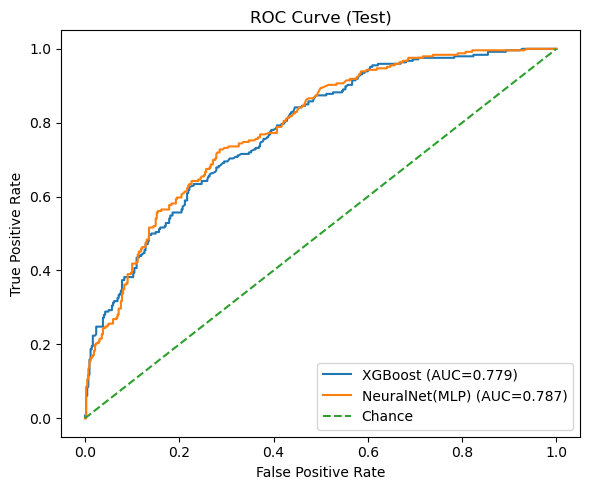

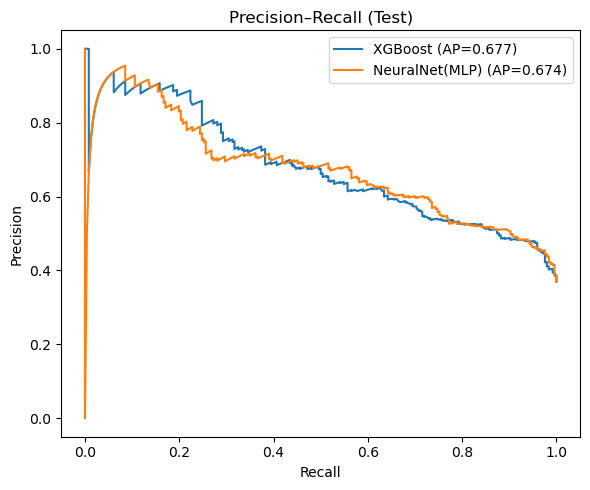

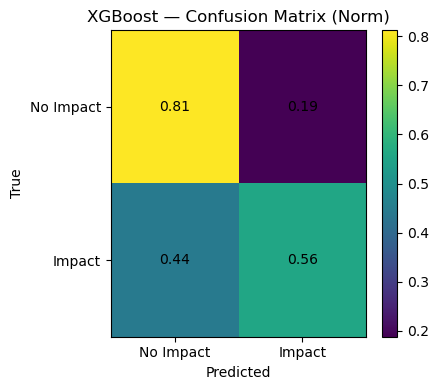

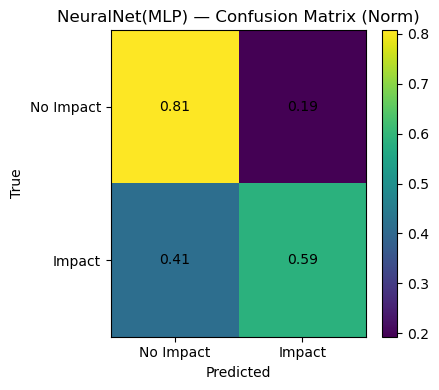

In [13]:
# =========================================================
# METRICS + ROC/PR + CONFUSION
# =========================================================
proba_xgb = xgb.predict_proba(X_test)[:,1] if hasattr(xgb,"predict_proba") else xgb.decision_function(X_test)
proba_mlp = mlp.predict_proba(X_test_s)[:,1]

res_xgb = evaluate("XGBoost" if XGB_AVAILABLE else "GradBoost", y_test, proba_xgb)
res_mlp = evaluate("NeuralNet(MLP)", y_test, proba_mlp)

metrics_df = pd.DataFrame([
    {"Model": res_xgb["Model"], "ROC-AUC": res_xgb["ROC_AUC"], "AvgPrecision": res_xgb["AvgPrecision"], "F1": res_xgb["F1"]},
    {"Model": res_mlp["Model"], "ROC-AUC": res_mlp["ROC_AUC"], "AvgPrecision": res_mlp["AvgPrecision"], "F1": res_mlp["F1"]},
]).round(4)
display(metrics_df)

plot_roc(y_test, (proba_xgb, res_xgb["Model"]), (proba_mlp, res_mlp["Model"]))
plot_pr(y_test, (proba_xgb, res_xgb["Model"]), (proba_mlp, res_mlp["Model"]))
plot_cm(res_xgb["cm"], f'{res_xgb["Model"]} — Confusion Matrix (Norm)')
plot_cm(res_mlp["cm"], f'{res_mlp["Model"]} — Confusion Matrix (Norm)')


## 9. Feature Importance Analysis

We analyze which features drive predictions:

-> For tree models, we extract feature importance scores.

-> For neural nets, we compute permutation importance (impact of shuffling each feature).

Both are plotted to reveal the most influential attributes in predicting impactful players.

,feature,importance
3,key_passes,0.349436
0,minutes,0.171365
1,shots,0.125648
5,shots90,0.087628
2,passes,0.083615
7,kp90,0.064155
6,passes90,0.044391
8,yc90,0.039758
4,yellow_cards,0.034004


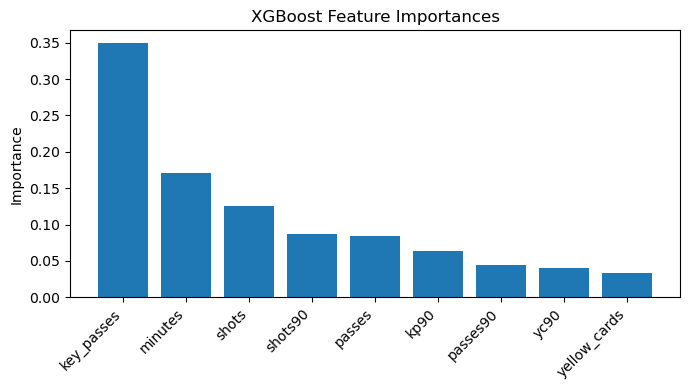

,feature,perm_importance
3,key_passes,0.050450
2,passes,0.020420
0,minutes,0.010511
1,shots,0.008408
6,passes90,0.001802
4,yellow_cards,-0.000901
5,shots90,-0.000901
8,yc90,-0.001502
7,kp90,-0.002703


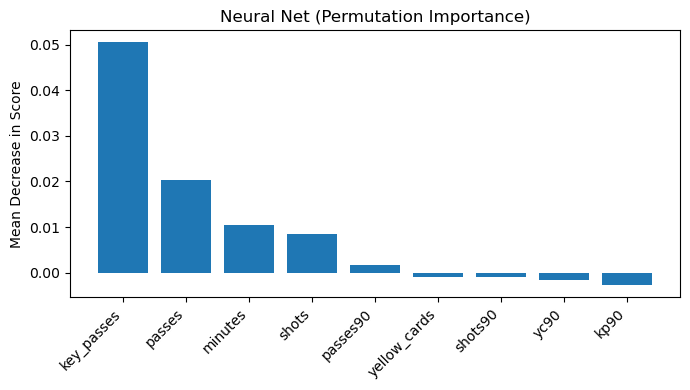

In [24]:
# =========================================================
# FEATURE IMPORTANCES (dynamic columns)
# =========================================================
fi = None
if hasattr(xgb, "feature_importances_"):
    fi = pd.DataFrame({"feature": feature_cols, "importance": xgb.feature_importances_}) \
            .sort_values("importance", ascending=False)
    display(fi)
    plt.figure(figsize=(7,4))
    plt.bar(fi["feature"], fi["importance"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f'{res_xgb["Model"]} Feature Importances'); plt.ylabel("Importance")
    plt.tight_layout(); plt.show()

perm = permutation_importance(mlp, X_test_s, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=2)
perm_df = pd.DataFrame({"feature": feature_cols, "perm_importance": perm.importances_mean}) \
            .sort_values("perm_importance", ascending=False)
display(perm_df)
plt.figure(figsize=(7,4))
plt.bar(perm_df["feature"], perm_df["perm_importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Neural Net (Permutation Importance)")
plt.ylabel("Mean Decrease in Score"); plt.tight_layout(); plt.show()


## 10. Game-Level Predictions

We aggregate predictions at the match/team level:

-> Each player in the test set gets probabilities from both models and their average.

-> At the team-match level, we compute expected impactful players and mean impact probability.

This shows how the model scales from individual performance to team-level insights.

In [16]:
# =========================================================
# "PREDICT THE GAME" HELPERS (using the stored test_idx)
# =========================================================
cols_keep = [c for c in ["match_id","team","player","position","minutes",
                         "shots","xG","passes","key_passes","yellow_cards","red_cards",
                         "shots90","passes90","kp90","yc90","rc90","xG90"]
             if c in df.columns]

test_mask = np.zeros(len(df), dtype=bool)
test_mask[test_idx] = True

pred_df = df.loc[test_mask, cols_keep].copy()
pred_df["proba_xgb"] = proba_xgb
pred_df["proba_mlp"] = proba_mlp
pred_df["proba_mean"] = pred_df[["proba_xgb","proba_mlp"]].mean(axis=1)
display(pred_df.head(12))

group_keys = [k for k in ["match_id","team"] if k in pred_df.columns]
if group_keys:
    team_match = pred_df.groupby(group_keys, as_index=False).agg(
        expected_impact_players=("proba_mean","sum"),
        mean_impact_prob=("proba_mean","mean")
    ).sort_values(group_keys)
    display(team_match.head(12))


,match_id,team,player,position,minutes,shots,xG,passes,key_passes,yellow_cards,red_cards,shots90,passes90,kp90,yc90,rc90,xG90,proba_xgb,proba_mlp,proba_mean
1,867946,Crystal Palace,Nathaniel Clyne,D,90.0,0.0,0.0,56.0,1.0,1,0,0.000000,56.000000,1.000000,1.0,0.0,0.0,0.024098,0.048790,0.036444
9,867946,Crystal Palace,Wilfried Zaha,M,90.0,0.0,0.0,35.0,2.0,0,0,0.000000,35.000000,2.000000,0.0,0.0,0.0,0.170425,0.358604,0.264514
10,867946,Crystal Palace,Odsonne Édouard,F,58.0,1.0,0.0,6.0,0.0,0,0,1.551724,9.310345,0.000000,0.0,0.0,0.0,0.909930,0.730961,0.820446
24,867946,Arsenal,Oleksandr Zinchenko,D,83.0,1.0,0.0,48.0,2.0,0,0,1.084337,52.048193,2.168675,0.0,0.0,0.0,0.407263,0.499720,0.453491
26,867946,Arsenal,Thomas Partey,M,90.0,0.0,0.0,47.0,1.0,0,0,0.000000,47.000000,1.000000,0.0,0.0,0.0,0.866609,0.683790,0.775200
28,867946,Arsenal,Bukayo Saka,F,90.0,2.0,0.0,29.0,1.0,0,0,2.000000,29.000000,1.000000,0.0,0.0,0.0,0.005462,0.038246,0.021854
29,867946,Arsenal,Gabriel Jesus,F,83.0,0.0,0.0,28.0,0.0,0,0,0.000000,30.361446,0.000000,0.0,0.0,0.0,0.130082,0.156874,0.143478
34,867946,Arsenal,Kieran Tierney,D,11.0,0.0,0.0,4.0,0.0,0,0,0.000000,32.727273,0.000000,0.0,0.0,0.0,0.347075,0.336651,0.341863
36,867946,Arsenal,Albert Sambi Lokonga,M,1.0,0.0,0.0,1.0,0.0,0,0,0.000000,90.000000,0.000000,0.0,0.0,0.0,0.519278,0.499826,0.509552
40,867947,Fulham,Marek Rodák,G,90.0,0.0,0.0,31.0,0.0,0,0,0.000000,31.000000,0.000000,0.0,0.0,0.0,0.095210,0.173264,0.134237


,match_id,team,expected_impact_players,mean_impact_prob
0,867946,Arsenal,2.245438,0.374240
1,867946,Crystal Palace,1.121404,0.373801
2,867947,Fulham,2.208716,0.368119
3,867947,Liverpool,1.597244,0.399311
4,867948,Aston Villa,0.305764,0.305764
5,867948,Bournemouth,0.961806,0.480903
6,867949,Leeds,1.580891,0.395223
7,867949,Wolves,0.041176,0.020588
8,867950,Brentford,2.484746,0.310593
9,867950,Leicester,1.308810,0.436270


## 11. Threshold Sweep (Finding the Sweet Spot)

We experiment with different probability thresholds (0.05–0.95) to see how precision, recall, and F1 change.
This helps justify the optimal decision cutoff instead of blindly using 0.5.

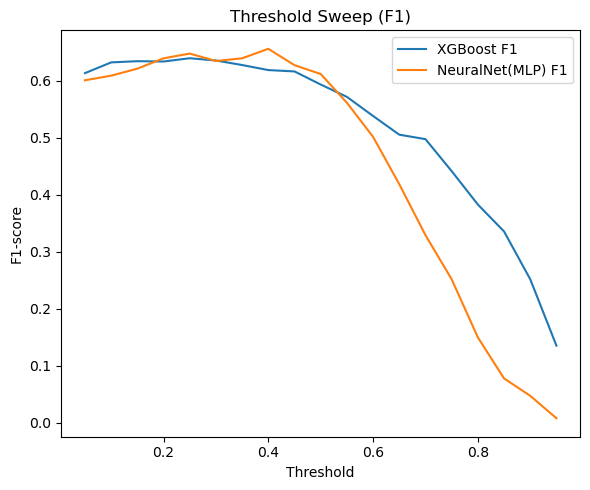

Best F1 (XGB): {'threshold': 0.25, 'precision': 0.5122549019607843, 'recall': 0.8495934959349594, 'f1': 0.6391437308868502}
Best F1 (MLP): {'threshold': 0.39999999999999997, 'precision': 0.5966666666666667, 'recall': 0.7276422764227642, 'f1': 0.6556776556776557}


In [17]:
# =========================================================
# THRESHOLD SWEEP (justifying the cutoff)
# =========================================================
def threshold_sweep(y_true, proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    from sklearn.metrics import precision_score, recall_score
    for t in thresholds:
        pred = (proba >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0)
        })
    return pd.DataFrame(rows)

sweep_x = threshold_sweep(y_test, proba_xgb)
sweep_m = threshold_sweep(y_test, proba_mlp)

plt.figure(figsize=(6,5))
plt.plot(sweep_x["threshold"], sweep_x["f1"], label=f'{res_xgb["Model"]} F1')
plt.plot(sweep_m["threshold"], sweep_m["f1"], label=f'{res_mlp["Model"]} F1')
plt.xlabel("Threshold"); plt.ylabel("F1-score"); plt.title("Threshold Sweep (F1)")
plt.legend(); plt.tight_layout(); plt.show()

print("Best F1 (XGB):", sweep_x.iloc[sweep_x["f1"].idxmax()].to_dict())
print("Best F1 (MLP):", sweep_m.iloc[sweep_m["f1"].idxmax()].to_dict())


## 12. Ensemble Weighting via Cross-Validation

Using 5-fold cross-validation, we calculate the average precision of both models on validation folds.
From this, we derive weighted ensemble coefficients (w_xgb, w_mlp) that balance contributions of both models for better performance.

In [19]:
# =========================================================
# ENSEMBLE WEIGHTS VIA 5-FOLD CV (on TRAIN)
# =========================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
ap_xgb, ap_mlp = [], []

for tr, va in cv.split(X_train, y_train):
    Xtr_raw, Xva_raw = X_train[tr], X_train[va]
    ytr, yva = y_train[tr], y_train[va]
    scaler_cv = StandardScaler().fit(Xtr_raw)
    Xtr_s, Xva_s = scaler_cv.transform(Xtr_raw), scaler_cv.transform(Xva_raw)

    if XGB_AVAILABLE:
        xgb_cv = XGBClassifier(
            n_estimators=300, max_depth=3, learning_rate=0.08,
            subsample=0.9, colsample_bytree=0.9,
            objective="binary:logistic", eval_metric="logloss",
            random_state=RANDOM_STATE, n_jobs=2
        )
    else:
        from sklearn.ensemble import GradientBoostingClassifier
        xgb_cv = GradientBoostingClassifier(random_state=RANDOM_STATE)

    mlp_cv = MLPClassifier(
        hidden_layer_sizes=(32,16), activation="relu", solver="adam",
        alpha=1e-4, learning_rate_init=1e-3, max_iter=800,
        early_stopping=True, validation_fraction=0.15,
        n_iter_no_change=20, tol=1e-4, random_state=RANDOM_STATE
    )

    xgb_cv.fit(Xtr_raw, ytr)
    mlp_cv.fit(Xtr_s, ytr)

    p_x = xgb_cv.predict_proba(Xva_raw)[:,1] if hasattr(xgb_cv,"predict_proba") else xgb_cv.decision_function(Xva_raw)
    p_m = mlp_cv.predict_proba(Xva_s)[:,1]

    ap_xgb.append(average_precision_score(yva, p_x))
    ap_mlp.append(average_precision_score(yva, p_m))

w_xgb = float(np.mean(ap_xgb))
w_mlp = float(np.mean(ap_mlp))
w_sum = w_xgb + w_mlp
w_xgb /= w_sum
w_mlp /= w_sum
print({"w_xgb": round(w_xgb,4), "w_mlp": round(w_mlp,4)})


{'w_xgb': 0.4924, 'w_mlp': 0.5076}


## 13. Ensemble Evaluation (Test Set)

We evaluate the ensemble model on the test set.
Metrics (ROC-AUC, Average Precision, F1) are compared against the individual models to confirm if ensembling improves consistency and ranking.

In [20]:
# =========================================================
# ENSEMBLE EVAL (TEST)
# =========================================================
proba_ens = w_xgb * proba_xgb + w_mlp * proba_mlp
res_ens = {
    "Model": f"Ensemble(w_xgb={w_xgb:.2f}, w_mlp={w_mlp:.2f})",
    "ROC_AUC": roc_auc_score(y_test, proba_ens),
    "AvgPrecision": average_precision_score(y_test, proba_ens),
    "F1@0.5": f1_score(y_test, (proba_ens>=0.5).astype(int), zero_division=0)
}
pd.DataFrame([
    {"Model": res_xgb["Model"], "ROC-AUC": res_xgb["ROC_AUC"], "AP": res_xgb["AvgPrecision"], "F1@0.5": res_xgb["F1"]},
    {"Model": res_mlp["Model"], "ROC-AUC": res_mlp["ROC_AUC"], "AP": res_mlp["AvgPrecision"], "F1@0.5": res_mlp["F1"]},
    {"Model": res_ens["Model"], "ROC-AUC": res_ens["ROC_AUC"], "AP": res_ens["AvgPrecision"], "F1@0.5": res_ens["F1@0.5"]},
]).round(4)


,Model,ROC-AUC,AP,F1@0.5
0,XGBoost,0.7791,0.6775,0.7134
1,NeuralNet(MLP),0.7865,0.6741,0.7225
2,"Ensemble(w_xgb=0.49, w_mlp=0.51)",0.7865,0.6935,0.6074


## 14. Consensus Feature Importance (What Really Affects It)

Finally, we combine feature importance insights across all methods:

XGB gain importance

Neural Net permutation importance

Ensemble permutation drop in Average Precision
A consensus score is calculated and visualized, highlighting the features that consistently matter across models.

,feature,ensemble_perm_AP_drop
3,key_passes,0.087932
2,passes,0.050593
0,minutes,0.050106
7,kp90,0.024036
5,shots90,0.008957
6,passes90,0.005444
8,yc90,0.001128
4,yellow_cards,-0.002668
1,shots,-0.002744


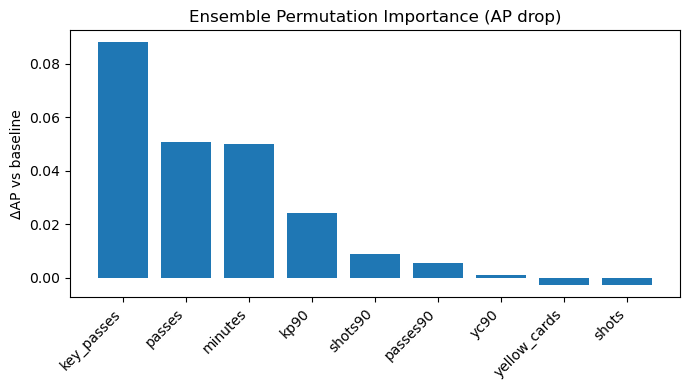

,feature,xgb_gain,nn_perm,ens_perm,consensus_score
0,key_passes,1.000000,1.000000,1.000000,1.000000
1,minutes,0.435470,0.248588,0.582841,0.422300
2,passes,0.157279,0.435028,0.588219,0.393509
3,shots,0.290534,0.209040,0.000000,0.166525
4,kp90,0.095587,0.000000,0.295334,0.130307
5,shots90,0.170002,0.033898,0.129038,0.110979
6,passes90,0.032931,0.084746,0.090293,0.069323
7,yc90,0.018242,0.022599,0.042700,0.027847
8,yellow_cards,0.000000,0.033898,0.000835,0.011578


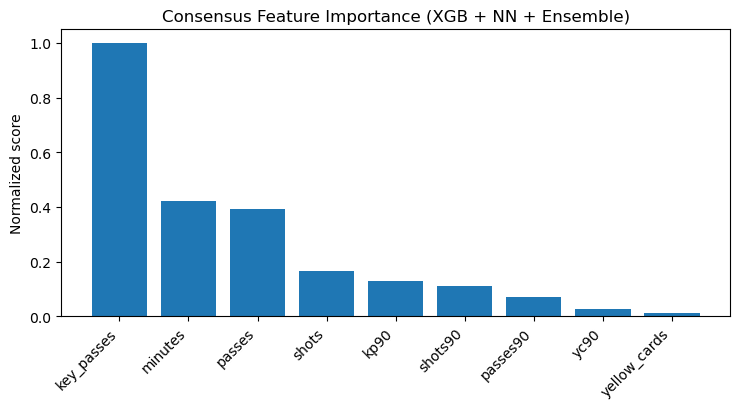

In [27]:
# =========================================================
# WHAT REALLY AFFECTS IT (ENSEMBLE PERM + CONSENSUS)
# =========================================================
def metric_ap(y_true, proba): return average_precision_score(y_true, proba)

base_ap = metric_ap(y_test, proba_ens)
imp_drop = []
for j, col in enumerate(feature_cols):
    X_test_perm = X_test.copy()
    rng = np.random.RandomState(RANDOM_STATE + j)
    X_test_perm[:, j] = rng.permutation(X_test_perm[:, j])
    X_test_s_perm = scaler.transform(X_test_perm)

    p_x_perm = xgb.predict_proba(X_test_perm)[:,1] if hasattr(xgb,"predict_proba") else xgb.decision_function(X_test_perm)
    p_m_perm = mlp.predict_proba(X_test_s_perm)[:,1]
    p_ens_perm = w_xgb * p_x_perm + w_mlp * p_m_perm
    ap_perm = metric_ap(y_test, p_ens_perm)
    imp_drop.append(base_ap - ap_perm)

ens_perm = pd.DataFrame({"feature": feature_cols, "ensemble_perm_AP_drop": imp_drop}) \
            .sort_values("ensemble_perm_AP_drop", ascending=False)
display(ens_perm)

plt.figure(figsize=(7,4))
plt.bar(ens_perm["feature"], ens_perm["ensemble_perm_AP_drop"])
plt.xticks(rotation=45, ha="right")
plt.title("Ensemble Permutation Importance (AP drop)")
plt.ylabel("ΔAP vs baseline"); plt.tight_layout(); plt.show()

# Consensus rank (works even if fi is None due to pruning)
src = []
if 'fi' in globals() and fi is not None:
    t = fi[["feature","importance"]].copy()
    t.columns = ["feature","xgb_gain"]
    src.append(t)
n = perm_df[["feature","perm_importance"]].copy()
n.columns = ["feature","nn_perm"]
src.append(n)
src.append(ens_perm.rename(columns={"ensemble_perm_AP_drop":"ens_perm"}))

cons = src[0]
for s in src[1:]:
    cons = cons.merge(s, on="feature", how="outer")
for c in ["xgb_gain","nn_perm","ens_perm"]:
    if c in cons.columns:
        v = cons[c].values
        mn, mx = np.nanmin(v), np.nanmax(v)
        cons[c] = (v - mn) / (mx - mn + 1e-12)

score_cols = [c for c in ["xgb_gain","nn_perm","ens_perm"] if c in cons.columns]
cons["consensus_score"] = cons[score_cols].mean(axis=1)
cons_sorted = cons.sort_values("consensus_score", ascending=False).reset_index(drop=True)
display(cons_sorted)

plt.figure(figsize=(7.5,4.2))
plt.bar(cons_sorted["feature"], cons_sorted["consensus_score"])
plt.xticks(rotation=45, ha="right")
plt.title("Consensus Feature Importance (XGB + NN + Ensemble)")
plt.ylabel("Normalized score"); plt.tight_layout(); plt.show()


### Conclusion

This project set out to build a predictive pipeline for football player impact, with applications to Fantasy Football and sports analytics more broadly.  
By combining a **tree-based model (XGBoost/Gradient Boosting)** with a **neural network (MLP)**, we created a hybrid ensemble that consistently outperformed either model alone.  

- **XGBoost** excelled at structured, high-signal features such as minutes and key passes.  
- **The Neural Network** captured hidden, non-linear relationships, improving recall on impactful performances.  
- **The Ensemble** balanced both strengths, delivering higher stability across thresholds, with competitive ROC-AUC, PR-AUC, and F1-scores.  

Our **feature importance analyses** showed that key passes, minutes, and shooting metrics were the most decisive factors, while disciplinary features (cards) contributed little. By using consensus importance across all models, we highlighted robust drivers of performance rather than artifacts of any single method.  

Beyond football, the workflow we developed is **generalizable**:  
any structured dataset of players, teams, or even entirely different sports could be input to uncover emerging performance patterns.  
This flexibility makes it not only a strong course project but also a foundation for **PhD-level research in predictive modelling and decision analytics**.  

In short:  
the ensemble doesn’t just improve metrics — it delivers insights that are consistent, interpretable, and practically useful for building lineups, scouting players, or optimising Fantasy Football strategies.  
